**Section 1**

**Value at Risk** (VaR) is a widely used risk metric that estimates the maximum loss a portfolio is likely to suffer over a specified period with a given confidence level (e.g., 95%) and it focuses on the threshold where the worst losses occur.
While VaR only measures the threshold, **Expected Shortfall** looks beyond it, calculating the average of the worst-case losses beyond the VaR level,
providing a more comprehensive view of tail risk, making it useful for stress testing.



General definition for Value at Risk:
$$
\text{VaR}_{\alpha} = -\inf \{x \in \mathbb{R} : F(x) > \alpha \}
$$




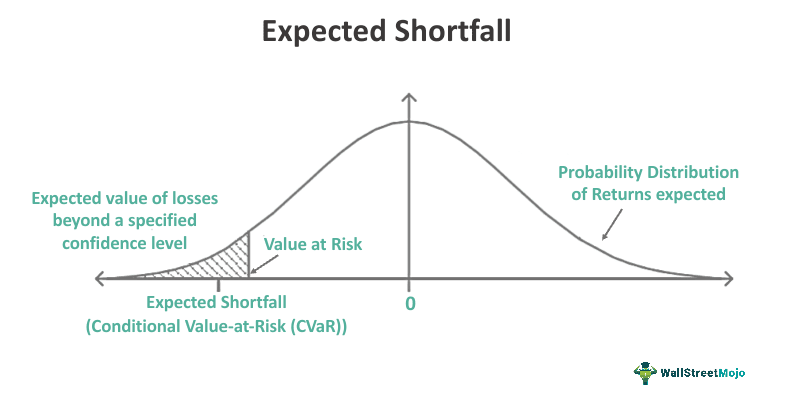

**Section 2**

There are multiple methods to compute VaR and ES, each with its own assumptions and strengths. The three approaches considered are:

1. **Historical Method**:
   - The historical approach relies on past logarithmic returns to calculate
     risk metrics such as VaR and ES. This method is entirely data-driven and avoids making any assumptions about the distribution of returns. By ranking past returns and examining the worst-performing percentiles, we determine the maximum potential loss (VaR) at a given confidence level, as well as the average loss beyond this threshold (ES). Although straightforward and effective in reflecting past trends, this approach may struggle to predict future risks in changing market conditions.



2. **Normal Parametric Method**:
$$
{VaR}_{\alpha} = \mu - z_{\alpha} \cdot \sigma
$$


$$\text{ES}_{\alpha} = \mu - \frac{\sigma \cdot \phi(z_{\alpha})}{1 - \alpha} $$
   - To complement the historical method, we use a parametric approach, which
     assumes that returns follow a normal distribution. This allows for the computation of risk metrics using statistical parameters such as the mean and standard deviation. Leveraging the properties of the standard normal distribution, we can estimate VaR and ES more quickly, as the process involves analytical calculations rather than iterative sorting. Using the mean (µ) and standard deviation (σ) of returns, we calculate VaR as a function of the z-score corresponding to the desired confidence level. However, it assumes normality, which may not hold during extreme market events.



3. **MonteCarlo Method**:
   - The Monte Carlo method uses simulation to model the potential distribution
     of portfolio returns. It is particularly useful for complex portfolios or when returns deviate from normality. This technique generates thousands of hypothetical return scenarios based on the historical mean and volatility, creating a robust probabilistic model of future performance. By simulating potential outcomes, we capture a wide range of market behaviors, including extreme events that may not be evident in historical data or a parametric framework. Despite its computational intensity, this method provides a highly flexible and realistic assessment of risk. VaR is then estimated as the percentile of the simulated distribution of returns while ES is computed as the average loss beyond the VaR in the simulated return distribution.

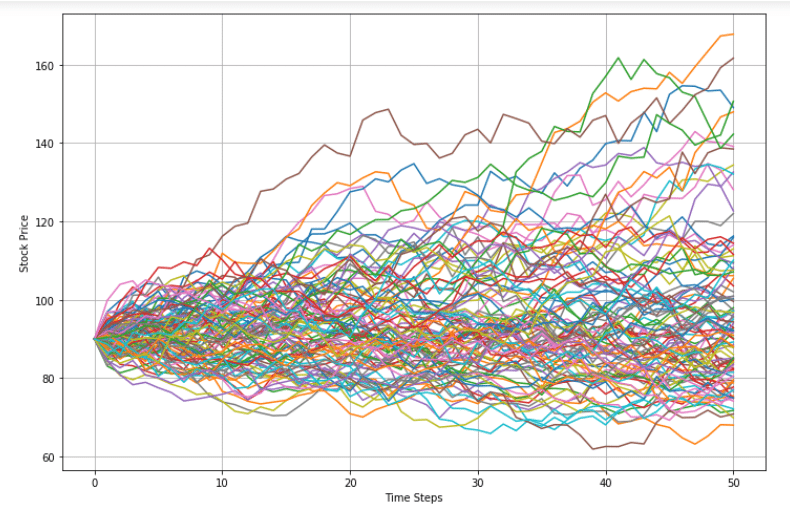

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
from scipy.stats import norm, t
from scipy.stats import kurtosis, skew

In [ ]:
days = 1
ticker = 'AAPL'
today = datetime.today()
yesterday = today - timedelta(days = 1)
start = today - timedelta(days * 365)
end = yesterday


In [ ]:
def getData(ticker,start,end):
  price_data = pd.DataFrame(yf.download(ticker, start, end))
  price_data ['Log Returns'] = np.log(price_data['Adj Close'] / price_data['Adj Close'].shift(1))
  price_data = price_data.dropna()
  log_returns = price_data ['Log Returns']
  sorted_log_returns = sorted(np.array(price_data['Log Returns']))
  return log_returns, sorted_log_returns

def meanReturn(log_returns):
  mean_return = np.mean(log_returns)
  return mean_return

def dailyVol(log_returns):
  daily_std = np.std(log_returns)
  return daily_std

#1. HISTORICAL METHOD
def historicalVaR_ES(sorted_log_returns, CI):
  historical_VaR = np.quantile(sorted_log_returns, (1 - CI))
  returns_beyond_VaR = np.array(sorted_log_returns) < historical_VaR
  slice_of_log_returns = np.array(sorted_log_returns)[returns_beyond_VaR]
  Expected_shortfall = (np.mean(slice_of_log_returns))
  return historical_VaR,Expected_shortfall

#2. PARAMETRIC METHOD
def parametric_VaR_ES(mean_return, daily_std, dof,distribution = 'normal', CI = 0.95):
  z_alpha = norm.ppf(1 - CI)
  if distribution == 'normal':
    parametric_VaR = -(mean_return - (z_alpha * daily_std ))
    parametric_Expected_shortfall = mean_return  - (daily_std * norm.pdf(z_alpha)) / (1 - CI)
  elif distribution == 't-distribution':
    nu = dof
    x_anu = t.ppf(1-CI, nu)
    parametric_VaR = -(np.sqrt((nu-2)/nu) * t.ppf(CI,nu) * daily_std - mean_return)
    parametric_Expected_shortfall = -(-1/(1-CI) * (1-nu)**-1 * (nu-2+x_anu**2) * t.pdf(x_anu,nu)*daily_std - mean_return)
  else:
    raise TypeError("expected distribution to be normal or t")
  return parametric_VaR, parametric_Expected_shortfall

#3. MONTECARLO METHOD
def monteCarlo_VaR_ES(mean_return, daily_std, CI=0.95, num_simulations=10000, simulation_horizon=1):
    simulated_returns = np.random.normal(mean_return, daily_std, (simulation_horizon, num_simulations))
    initial_investment = 1000000
    portfolio_values = initial_investment * np.exp(simulated_returns.sum(axis=0))
    portfolio_returns = np.log(portfolio_values / initial_investment)
    VaR_monte_carlo = np.quantile(portfolio_returns, 1 - CI)
    ES_monte_carlo = portfolio_returns[portfolio_returns < VaR_monte_carlo].mean()
    return portfolio_returns, VaR_monte_carlo, ES_monte_carlo

In [ ]:
CI = 0.95

dof = 6

log_returns, sorted_log_returns = getData(ticker,start,end)

mean_return = meanReturn(log_returns)

daily_std = dailyVol(log_returns)

historical_VaR, Expected_shortfall = historicalVaR_ES(sorted_log_returns, CI)

parametric_n_VaR, parametric_n_Expectedshortfall = parametric_VaR_ES(mean_return, daily_std,dof)

parametric_t_VaR, parametric_t_Expectedshortfall = parametric_VaR_ES(mean_return, daily_std,dof,distribution = 't-distribution')

portfolio_returns, VaR_monte_carlo, ES_monte_carlo= monteCarlo_VaR_ES(mean_return, daily_std, CI)


[*********************100%***********************]  1 of 1 completed


**Section 3**

The analysis is conducted with a 95% confidence level, meaning we expect losses to exceed the Value at Risk (VaR) threshold in only 5% of cases. Based on the results, the **Historical VaR** is calculated to be **-2.20%**, indicating that the portfolio is expected to lose at least 2.20% of its value in the worst 5% of trading days. Additionally, the **Expected Shortfall (ES)** is estimated at **-3.005%**, reflecting the average loss in these worst 5% cases. Unlike VaR, which focuses on a single threshold, ES considers the magnitude of losses beyond that threshold, offering a more comprehensive view of tail risk.
The graph illustrates the distribution of daily log returns, with key risk metrics superimposed for visual clarity. The **blue curve** represents the estimated density of historical log returns, showing the probability distribution of daily returns, while **purple dashed line** indicates the Historical VaR (-2.20%), marking the return level below which the worst 5% of losses are found. Instead, The **red dashed line** represents the Expected Shortfall (-3.005%), highlighting the average loss within this critical tail region. This visual comparison emphasizes the distinction between the two measures and underscores the more conservative nature of ES.
From a risk management perspective, the VaR provides a useful benchmark for setting risk limits, as it identifies the minimum expected loss during adverse market conditions. However, due to its inability to account for the severity of losses beyond this threshold, the Expected Shortfall serves as a vital complement. It accounts for the potential magnitude of extreme losses, making it particularly valuable for portfolios with exposure to significant downside risk. Together, these metrics offer a comprehensive framework for assessing and managing financial risk.

In [ ]:
print(f"The VaR and Expected Shortfall calculated using historical are {historical_VaR:.3%} and {Expected_shortfall:.3%}")

The VaR and Expected Shortfall calculated using historical are -2.200% and -3.005%


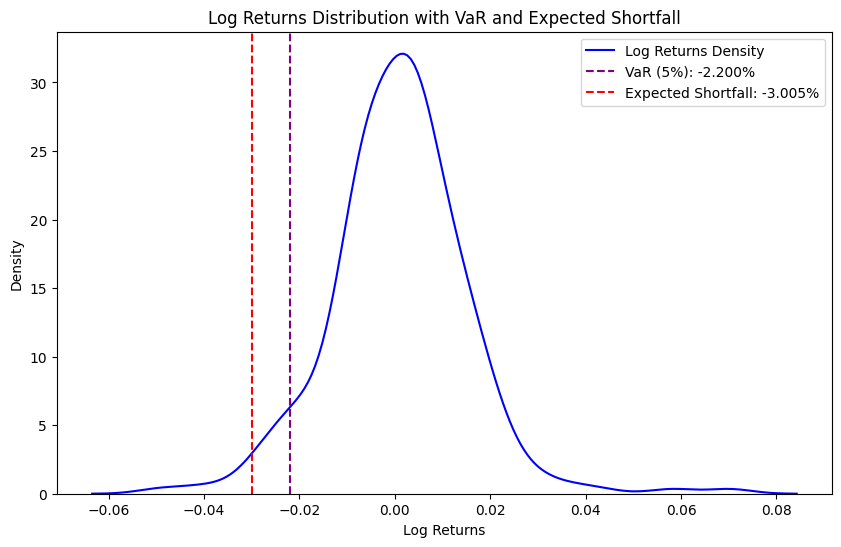

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.kdeplot(log_returns, color = 'blue', label="Log Returns Density")
plt.axvline(historical_VaR, color="purple", linestyle="--", linewidth=1.5, label=f"VaR (5%): {historical_VaR:.3%}")
plt.axvline(Expected_shortfall, color="red", linestyle="--", linewidth=1.5, label=f"Expected Shortfall: {Expected_shortfall:.3%}")
plt.title("Log Returns Distribution with VaR and Expected Shortfall")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

**Section 4**

With a confidence level of 95%, the **Parametric VaR** is estimated at **-2.250%**, meaning that the portfolio is expected to lose at least 2.250% of its value in the worst 5% of trading days. Similarly, the **Parametric ES** is determined to be **-2.841%**, capturing the average loss within the worst 5% tail.
The graph visualizes the normal distribution and overlays the key risk metrics. The **green curve** represents the kernel density estimate (KDE) of the historical log returns, approximating their probability distribution, while **purple dashed line** marks the Parametric VaR (-2.250%), illustrating the threshold for the worst 5% of losses based on the assumed normal distribution. The **red dashed line** signifies the Parametric ES (-2.841%), reflecting the mean loss within this critical region beyond the VaR threshold.
This plot highlights the main features of the parametric approach. While the parametric VaR is relatively straightforward to calculate, its reliability depends heavily on the assumption of normality. Deviations from this assumption, such as skewness or heavy tails in the actual return distribution, may result in underestimating or overestimating the risk. Nevertheless, the Expected Shortfall complements the VaR by quantifying the average magnitude of losses in extreme scenarios, offering a more comprehensive view of downside risk.


In [ ]:
print(f"The VaR and Expected Shortfall calculated using parametric method with a normal distribution are {parametric_n_VaR:.3%} and {parametric_n_Expectedshortfall:.3%}")

print(f"The VaR and Expected Shortfall calculated using parametric method with a t-distribution are {parametric_t_VaR:.3%} and {parametric_t_Expectedshortfall:.3%}")



The VaR and Expected Shortfall calculated using parametric method with a normal distribution are -2.419% and -2.834%
The VaR and Expected Shortfall calculated using parametric method with a t-distribution are -2.159% and -2.966%


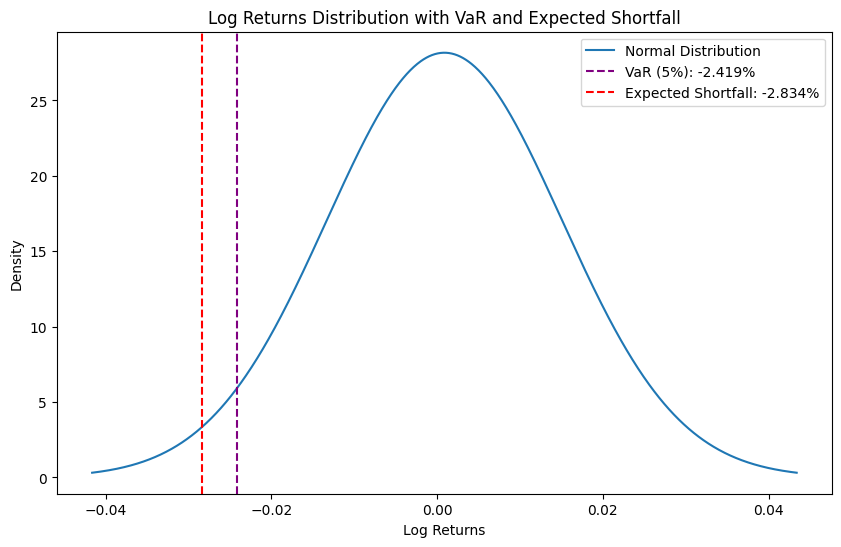

In [ ]:
fig = plt.figure(figsize=(10,6))
x = np.linspace(mean_return - 3*daily_std, mean_return + 3*daily_std, 1000)
y = norm.pdf(x, mean_return, daily_std)
plt.plot(x, y, label='Normal Distribution')
plt.axvline(parametric_n_VaR, color="purple", linestyle="--", linewidth=1.5, label=f"VaR (5%): {parametric_n_VaR:.3%}")
plt.axvline(parametric_n_Expectedshortfall, color="red", linestyle="--", linewidth=1.5, label=f"Expected Shortfall: {parametric_n_Expectedshortfall:.3%}")
plt.title("Log Returns Distribution with VaR and Expected Shortfall")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

**Section 5**

The plot above illustrates the distribution of log returns, alongside the Value at Risk (VaR) and Expected Shortfall (ES) calculated using the **Monte Carlo** simulation method. The **black curve** represents the kernel density estimation (KDE) of the log returns, offering a smooth approximation of the return distribution. Monte Carlo simulation is a highly flexible and robust method for risk estimation, particularly suitable when asset returns deviate from normality, generating a large number of hypothetical return scenarios based on the historical mean and standard deviation of the data.
In this analysis, the 5% VaR obtained through the Monte Carlo method is marked by the **purple dashed** line at **\(-2.700\%\)**. This indicates that, under 95% of simulated scenarios, the portfolio’s loss will not exceed 2.700%. Meanwhile, the Expected Shortfall, shown by the red dashed line at **\(3.469\%\)**, captures the average loss in the worst 5% of cases, providing a more comprehensive measure of tail risk compared to VaR.
Notably, the Monte Carlo method tends to produce slightly higher risk estimates compared to the historical or parametric approaches. This is likely due to its ability to account for a broader range of potential outcomes, making it particularly useful for modeling risk in complex or non-linear market environments. As such, this method is invaluable for risk managers seeking a deeper understanding of extreme losses and the uncertainties associated with financial portfolios.

In [ ]:
print("Kurtosis:", kurtosis(log_returns))
print("Skewness:", skew(log_returns))

Kurtosis: 3.346063487336938
Skewness: 0.38852340714234923


In [ ]:
print(f"The VaR and Expected Shortfall calculated using monte carlo simulation are {VaR_monte_carlo:.3%} and {ES_monte_carlo:.3%}")

The VaR and Expected Shortfall calculated using monte carlo simulation are -2.199% and -2.800%


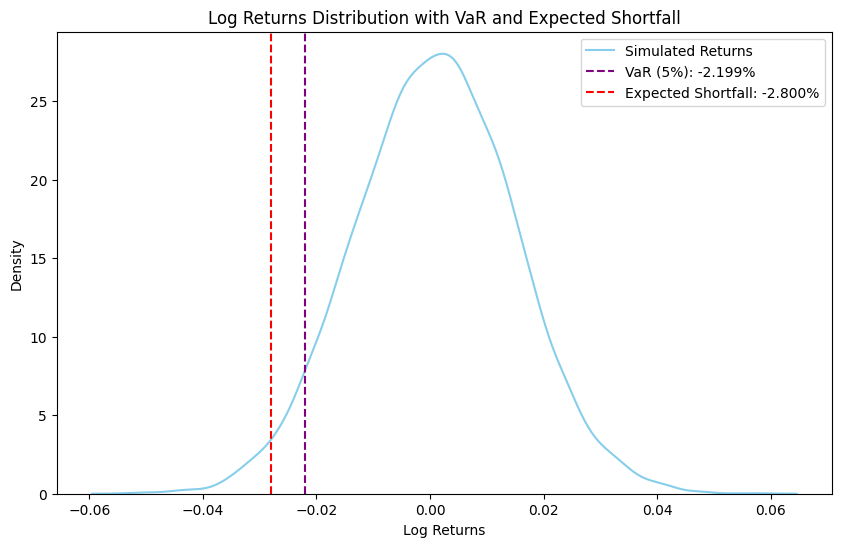

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.kdeplot(portfolio_returns,color="skyblue", label="Simulated Returns")
plt.axvline(VaR_monte_carlo, color="purple", linestyle="--", linewidth=1.5, label=f"VaR (5%): {VaR_monte_carlo:.3%}")
plt.axvline(ES_monte_carlo, color="red", linestyle="--", linewidth=1.5, label=f"Expected Shortfall: {ES_monte_carlo:.3%}")
plt.title("Log Returns Distribution with VaR and Expected Shortfall")
plt.xlabel("Log Returns")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
# Create the DataFrame with properly formatted values
comparison_df = pd.DataFrame({
    'Historical%': [historical_VaR, Expected_shortfall],
    'Parametric-Normal%': [parametric_n_VaR, parametric_n_Expectedshortfall],
    'Parametric-T%': [parametric_t_VaR, parametric_t_Expectedshortfall],
    'Monte Carlo%': [VaR_monte_carlo, ES_monte_carlo]
})
comparison_df = comparison_df.apply(lambda x: round(x * 100, 3))
comparison_df.index = ['VaR', 'Expected Shortfall']
comparison_df

,Historical%,Parametric-Normal%,Parametric-T%,Monte Carlo%
VaR,-2.200,-2.419,-2.159,-2.199
Expected Shortfall,-3.005,-2.834,-2.966,-2.800
